# Facial Emotion Recognition Project

### Imports/Setup

In [1]:
# Imports
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout


import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf

# Set seed
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

### Load data

In [30]:
# Training/validation/testing data
ds_train_ = image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='categorical',
    image_size=[48, 48],
    color_mode='grayscale',
    seed=31415,
    validation_split=0.3,
    subset='training',
    shuffle=True
)
ds_valid_ = image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='categorical',
    image_size=[48, 48],
    color_mode='grayscale',
    seed=31415,
    validation_split=0.3,
    subset='validation',
    shuffle=False
)
ds_test_ = image_dataset_from_directory(
    'images/test',
    labels='inferred',
    label_mode='categorical',
    image_size=[48, 48],
    interpolation='nearest',
    shuffle=True
)

Found 28821 files belonging to 7 classes.
Using 20175 files for training.
Found 28821 files belonging to 7 classes.
Using 8646 files for validation.
Found 7066 files belonging to 7 classes.


In [31]:
# Data Pipeline
def preprocess_image(image, label):
    image = tf.image.resize(image, (48, 48))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(preprocess_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(preprocess_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Data Augmentation

In [71]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  # layers.RandomContrast([0, 255])
])

### Model based on VGG-16

In [72]:
# Sequential modeel
model = Sequential()

# Data augmentation
model.add(data_augmentation)

# Block 1
model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.1))

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.1))


# Block 3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.1))


# Block 4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Classification head
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=7,activation="softmax"))

### Model based on EfficientNet

In [70]:
from tensorflow.keras.applications import EfficientNetB4
Emodel = EfficientNetB4(include_top=False, input_shape=(48,48,3), pooling="max", weights='imagenet')

model = Sequential()
model.add(Emodel)
model.add(Flatten())
model.add(Dense(units=128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=7,activation="softmax"))


### Model Summary

In [ ]:
model.summary()

### Optimizer and loss function

In [73]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

### Early Stopping

In [74]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="models/eNet_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

### Training model + Plot learning curves

Epoch 1/25
631/631 [==============================] - ETA: 0s - loss: 1.8629 - accuracy: 0.2470
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to models\eNet_model.h5
631/631 [==============================] - 539s 852ms/step - loss: 1.8629 - accuracy: 0.2470 - val_loss: 1.9530 - val_accuracy: 0.0000e+00
Epoch 2/25
631/631 [==============================] - ETA: 0s - loss: 1.7932 - accuracy: 0.2564
Epoch 2: val_accuracy improved from 0.00000 to 0.06014, saving model to models\eNet_model.h5
631/631 [==============================] - 526s 834ms/step - loss: 1.7932 - accuracy: 0.2564 - val_loss: 1.9677 - val_accuracy: 0.0601
Epoch 3/25
631/631 [==============================] - ETA: 0s - loss: 1.7264 - accuracy: 0.2943
Epoch 3: val_accuracy improved from 0.06014 to 0.20090, saving model to models\eNet_model.h5
631/631 [==============================] - 522s 828ms/step - loss: 1.7264 - accuracy: 0.2943 - val_loss: 1.7320 - val_accuracy: 0.2009
Epoch 4/25
631/631 [=======

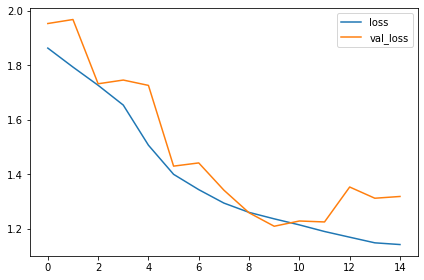

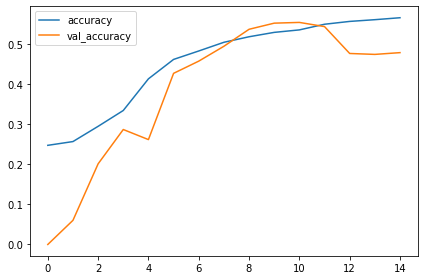

In [75]:
history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=25,
    callbacks=[es,mc]
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Saving model

In [40]:
model.save('models/eNet_model.h5')

### Loading model

In [12]:
from keras.models import load_model
model = load_model("emotion_model.h5")

In [ ]:
# predictions = model.predict(ds_test)
metrics = model.evaluate(ds_test)
metrics

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
predictions[:7]
pred = predictions > 0.3
# print(classification_report(list(ds_test.as_numpy_iterator()),pred))
# cm=confusion_matrix(ds_test.class_names, pred)
# print(cm)

5186


In [ ]:
print(list(ds_test.as_numpy_iterator())[0])